
# Optimal power flow model in Julia

In [1]:
import Pkg

# activate parent environment
Pkg.activate(normpath(joinpath(@__DIR__, ".")))
Pkg.resolve()
Pkg.instantiate()
Pkg.status()

using CSV
using DataFrames
using Dates
using TimeZones
using CairoMakie
using JuMP
import JSON
import MathOptInterface as MOI

using Revise
using OptHP

  Activating project at `c:\Users\lange\OneDrive\Projects\2024\EEM25\Congestion-Management-based-on-Thermal-Comfort`
  No Changes to `C:\Users\lange\OneDrive\Projects\2024\EEM25\Congestion-Management-based-on-Thermal-Comfort\Project.toml`
  No Changes to `C:\Users\lange\OneDrive\Projects\2024\EEM25\Congestion-Management-based-on-Thermal-Comfort\Manifest.toml`


Status `C:\Users\lange\OneDrive\Projects\2024\EEM25\Congestion-Management-based-on-Thermal-Comfort\Project.toml`
  [336ed68f] CSV v0.10.15
  [13f3f980] CairoMakie v0.13.1
  [a93c6f00] DataFrames v1.7.0
  [682c06a0] JSON v0.21.4
  [4076af6c] JuMP v1.23.6
  [b8f27783] MathOptInterface v1.35.1
  [2d871509] OptHP v1.0.0-DEV `OptHP`
  [295af30f] Revise v3.7.1
  [f269a46b] TimeZones v1.20.0
  [ade2ca70] Dates


## Load data

In [2]:
network = CSV.read("data/network.csv", DataFrame)
first(network, 5)

Row,StartNode,EndNode,Length,cable,Inom,R,X
,Int64,Int64,Float64,String7,Float64,Float64,Float64
1,47,15,22.21,50Al,0.12528,0.0142366,0.00188785
2,49,40,15.57,95Al,0.18386,0.0049824,0.00127674
3,26,41,18.26,95Al,0.18386,0.0058432,0.00149732
4,11,12,6.71,95Al,0.18386,0.0021472,0.00055022
5,12,27,6.52,95Al,0.18386,0.0020864,0.00053464


In [3]:
connections = CSV.read("data/user_connect.csv", DataFrame; delim=";")

# convert PV (str) to Float64
connections.PV = parse.(Float64, replace.(connections.PV, "," => "."))

first(connections, 5)

Row,Column1,Name,Node.ID,Node.Unom,Length,Type short,Connection value,load,PV,HP,Node
,Int64,Int64,Int64,Int64,String7,String15,String7,Int64,Float64,Int64,Int64
1,1,871694840006284337,46559968,230,"21,75",XLPE 4x6Cu,3x25 A,7000,4.0,1,50
2,2,871694840006288793,46563894,230,"2,22",XLPE 4x6Cu,3x25 A,7000,6.0,0,51
3,3,871694840006284108,11195660,230,"10,4",PVC 4x16Al,1x35 A,2000,2.2,0,52
4,4,871694840006284115,11195660,230,"10,4",PVC 4x16Al,1x35 A,500,2.2,0,53
5,5,871694840006284092,2573422,230,"7,33",PVC 4x16Al,1x35 A,2000,2.2,0,54


In [4]:
loads_real = CSV.read("data/UserPower.csv", DataFrame)
loads_real.time = DateTime.(loads_real.time, "m/d/yyyy H:M p")

loads_reactive = CSV.read("data/UserReactivePower.csv", DataFrame)
loads_reactive.time = DateTime.(loads_reactive.time, "m/d/yyyy H:M p")

# Filter for rows where the date is February 1, 2024
date = Date(2024, 2, 1)
loads_real = loads_real[Date.(loads_real.time) .== date, 3:end]
loads_reactive = loads_reactive[Date.(loads_reactive.time) .== date, 3:end]
first(loads_real, 5)

Row,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0280492,0.0327633,0.00789328,0.00216432,0.00870451,0.0066902,0.0190303,0.0208217,0.0316786,0.00885476,0.00227458,0.0100109,0.00389288,0.00391422,0.0217207,0.00663473,0.0137514,0.038904,0.0160743,0.0134882,0.0108427,0.044233,0.00783649,0.00964245,0.0327462,0.0462532,0.0159094,0.0085621,0.0220982,0.00783409,0.00924792,0.0118713,0.025677,0.019321,0.0138463,0.0255821,0.0
2,0.0194261,0.0201885,0.00556897,0.00150743,0.00557323,0.00408914,0.0129535,0.0161562,0.0188356,0.00547041,0.00150153,0.00703371,0.00301253,0.00301947,0.0136849,0.00469629,0.0110687,0.0308354,0.0108854,0.0103217,0.00754248,0.0315925,0.00559041,0.00759827,0.0213481,0.0281427,0.0101261,0.00647718,0.0135207,0.00579418,0.00582512,0.00873516,0.018251,0.013007,0.00943072,0.0178395,0.0
3,0.0222562,0.0222175,0.00583958,0.00149652,0.00583324,0.0040186,0.0131774,0.0146778,0.0221186,0.0063148,0.00160216,0.00741227,0.00291713,0.00310672,0.0151385,0.00471799,0.0109297,0.0284821,0.0112424,0.00954143,0.00796256,0.0309558,0.00559076,0.00797005,0.0227603,0.0303833,0.0111911,0.0058502,0.0160791,0.00646978,0.00603232,0.00961901,0.0193459,0.0125066,0.00844744,0.0178119,0.0
4,0.0236077,0.0214192,0.00656782,0.00158927,0.00727005,0.00480448,0.0148979,0.0172582,0.021615,0.00741563,0.00154189,0.00765452,0.00309739,0.00323702,0.0160809,0.00554229,0.012016,0.0365018,0.0146685,0.0129499,0.00916666,0.0329395,0.00737826,0.00877966,0.0230161,0.0328368,0.0108052,0.00674518,0.0164615,0.00639536,0.00619007,0.0105051,0.0187594,0.0137561,0.010025,0.020322,0.0
5,0.0258527,0.026771,0.00830569,0.00182058,0.00881239,0.00562766,0.0188999,0.0181352,0.0267452,0.00775641,0.00204764,0.00959481,0.00368743,0.00390459,0.0200733,0.00636839,0.0138178,0.0417959,0.0160488,0.0146582,0.00963903,0.0412269,0.00812958,0.00960557,0.0266,0.0380806,0.0141561,0.00851961,0.0213948,0.00755007,0.00783836,0.0122754,0.0233571,0.0186267,0.0109073,0.0241358,0.0


## Load state-space matrices

In [5]:
id = "H14"

A_d = Matrix(CSV.read("data/$(id)/$(id)_15min_A_exact.csv", DataFrame))
B_d = Matrix(CSV.read("data/$(id)/$(id)_15min_B_exact.csv", DataFrame))

H14_meta = Dict(
    "A" => A_d,
    "B" => B_d
)

meta = Dict(
    "H14" => H14_meta
)

Dict{String, Dict{String, Matrix{Float64}}} with 1 entry:
  "H14" => Dict("B"=>[0.00663784 0.00224598 0.166439; 9.37536e-5 2.65051e-6 0.0…

## Read weather data

In [6]:
weather_df = CSV.read("data/weather/weather.csv", DataFrame)
select!(weather_df, Not([:interpolated]))
rename!(weather_df, Dict("P_solar" => "Φ_s", "T_ambient" => "T_a"))

dt_format = "yyyy-mm-ddTHH:MM:SS.sss+zzzz"
weather_df.timestamp = ZonedDateTime.(String.(weather_df.timestamp), dt_format)
weather_df = interpolate_data(weather_df, 15)

# select a particular day
date = Date(2024, 4, 1)
weather_df = weather_df[Date.(weather_df.timestamp) .== date, :]

# add electricity price [€/kWh]
weather_df.λ_e .= 0.21

# convert Φ_s from W to kW
weather_df.Φ_s .= weather_df.Φ_s ./ 1000

println("Weather data shape: ", size(weather_df))
first(weather_df, 5)

Interpolating columns: [:Φ_s, :T_a]
Weather data shape: (96, 4)


Row,timestamp,Φ_s,T_a,λ_e
,ZonedDat…,Float64,Float64,Float64
1,2024-04-01T00:00:00+00:00,0.0,9.6,0.21
2,2024-04-01T00:15:00+00:00,0.0,9.45,0.21
3,2024-04-01T00:30:00+00:00,0.0,9.6,0.21
4,2024-04-01T00:45:00+00:00,0.0,9.3,0.21
5,2024-04-01T01:00:00+00:00,0.0,9.1,0.21


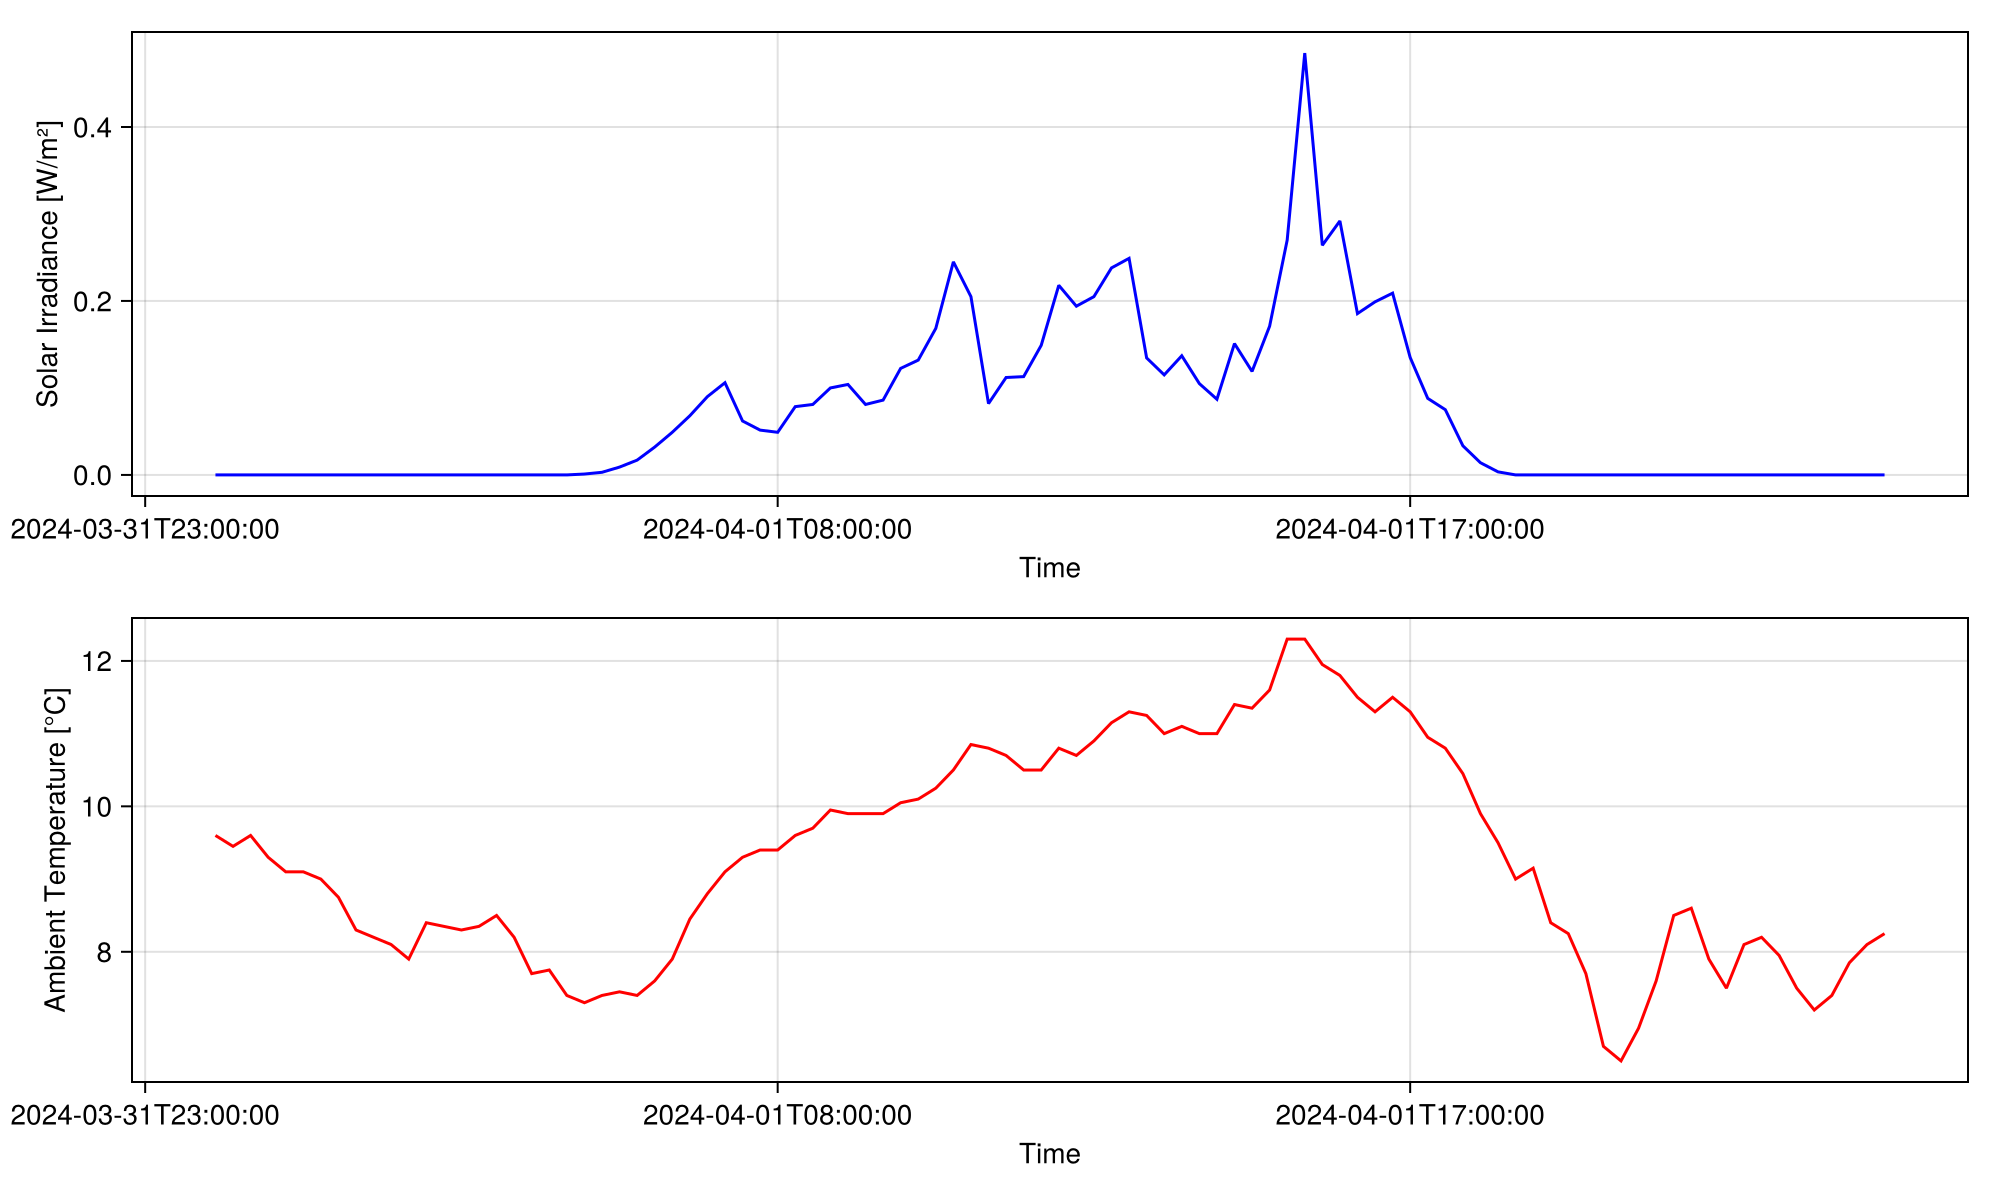

In [7]:
# plot the weather data
fig = Figure(; size = (1000, 600))

ax1 = Axis(fig[1, 1], xlabel="Time", ylabel="Solar Irradiance [W/m²]")
ax2 = Axis(fig[2, 1], xlabel="Time", ylabel="Ambient Temperature [°C]")

lines!(ax1, DateTime.(weather_df.timestamp), weather_df.Φ_s, color=:blue)
lines!(ax2, DateTime.(weather_df.timestamp), weather_df.T_a, color=:red)

fig

## Construct GEC

In [37]:
model = GEC(network=network, 
            connections=connections, 
            loads_real=loads_real, 
            loads_reactive=loads_reactive,   
            weather=weather_df,    
            meta = meta,
            silent=false 
)

Set parameter Username
Set parameter LicenseID to value 2599292
Academic license - for non-commercial use only - expires 2025-12-13
P_in: 1-dimensional DenseAxisArray{VariableRef,1,...} with index sets:
    Dimension 1, 1:96
And data, a 96-element Vector{VariableRef}:
 PLineFlow[1,(34, 0)]
 PLineFlow[2,(34, 0)]
 PLineFlow[3,(34, 0)]
 PLineFlow[4,(34, 0)]
 PLineFlow[5,(34, 0)]
 PLineFlow[6,(34, 0)]
 PLineFlow[7,(34, 0)]
 PLineFlow[8,(34, 0)]
 PLineFlow[9,(34, 0)]
 PLineFlow[10,(34, 0)]
 PLineFlow[11,(34, 0)]
 PLineFlow[12,(34, 0)]
 PLineFlow[13,(34, 0)]
 PLineFlow[14,(34, 0)]
 PLineFlow[15,(34, 0)]
 PLineFlow[16,(34, 0)]
 PLineFlow[17,(34, 0)]
 PLineFlow[18,(34, 0)]
 PLineFlow[19,(34, 0)]
 PLineFlow[20,(34, 0)]
 PLineFlow[21,(34, 0)]
 PLineFlow[22,(34, 0)]
 PLineFlow[23,(34, 0)]
 PLineFlow[24,(34, 0)]
 PLineFlow[25,(34, 0)]
 PLineFlow[26,(34, 0)]
 PLineFlow[27,(34, 0)]
 PLineFlow[28,(34, 0)]
 PLineFlow[29,(34, 0)]
 PLineFlow[30,(34, 0)]
 PLineFlow[31,(34, 0)]
 PLineFlow[32,(34, 0)]
 PLi

AssertionError: AssertionError: is_solved_and_feasible(model)

In [21]:
T_i = value.(model[:Te])[:, :, :i]

2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, 1:96
    Dimension 2, [64, 56, 84, 78, 66, 75, 57, 50, 67, 68, 82, 74]
And data, a 96×12 Matrix{Float64}:
 21.0     21.0     21.0     21.0     …  21.0     21.0     21.0     21.0
 20.9243  20.9243  20.9243  20.9243     20.9243  20.9243  20.9243  20.9243
 20.8495  20.8495  20.8495  20.8495     20.8495  20.8495  20.8495  20.8495
 20.7773  20.7773  20.7773  20.7773     20.7773  20.7773  20.7773  20.7773
 20.7048  20.7048  20.7048  20.7048     20.7048  20.7048  20.7048  20.7048
 20.6325  20.6325  20.6325  20.6325  …  20.6325  20.6325  20.6325  20.6325
 20.5617  20.5617  20.5617  20.5617     20.5617  20.5617  20.5617  20.5617
 20.4918  20.4918  20.4918  20.4918     20.4918  20.4918  20.4918  20.4918
 20.4216  20.4216  20.4216  20.4216     20.4216  20.4216  20.4216  20.4216
 20.3498  20.3498  20.3498  20.3498     20.3498  20.3498  20.3498  20.3498
  ⋮                                  ⋱                     ⋮       
 

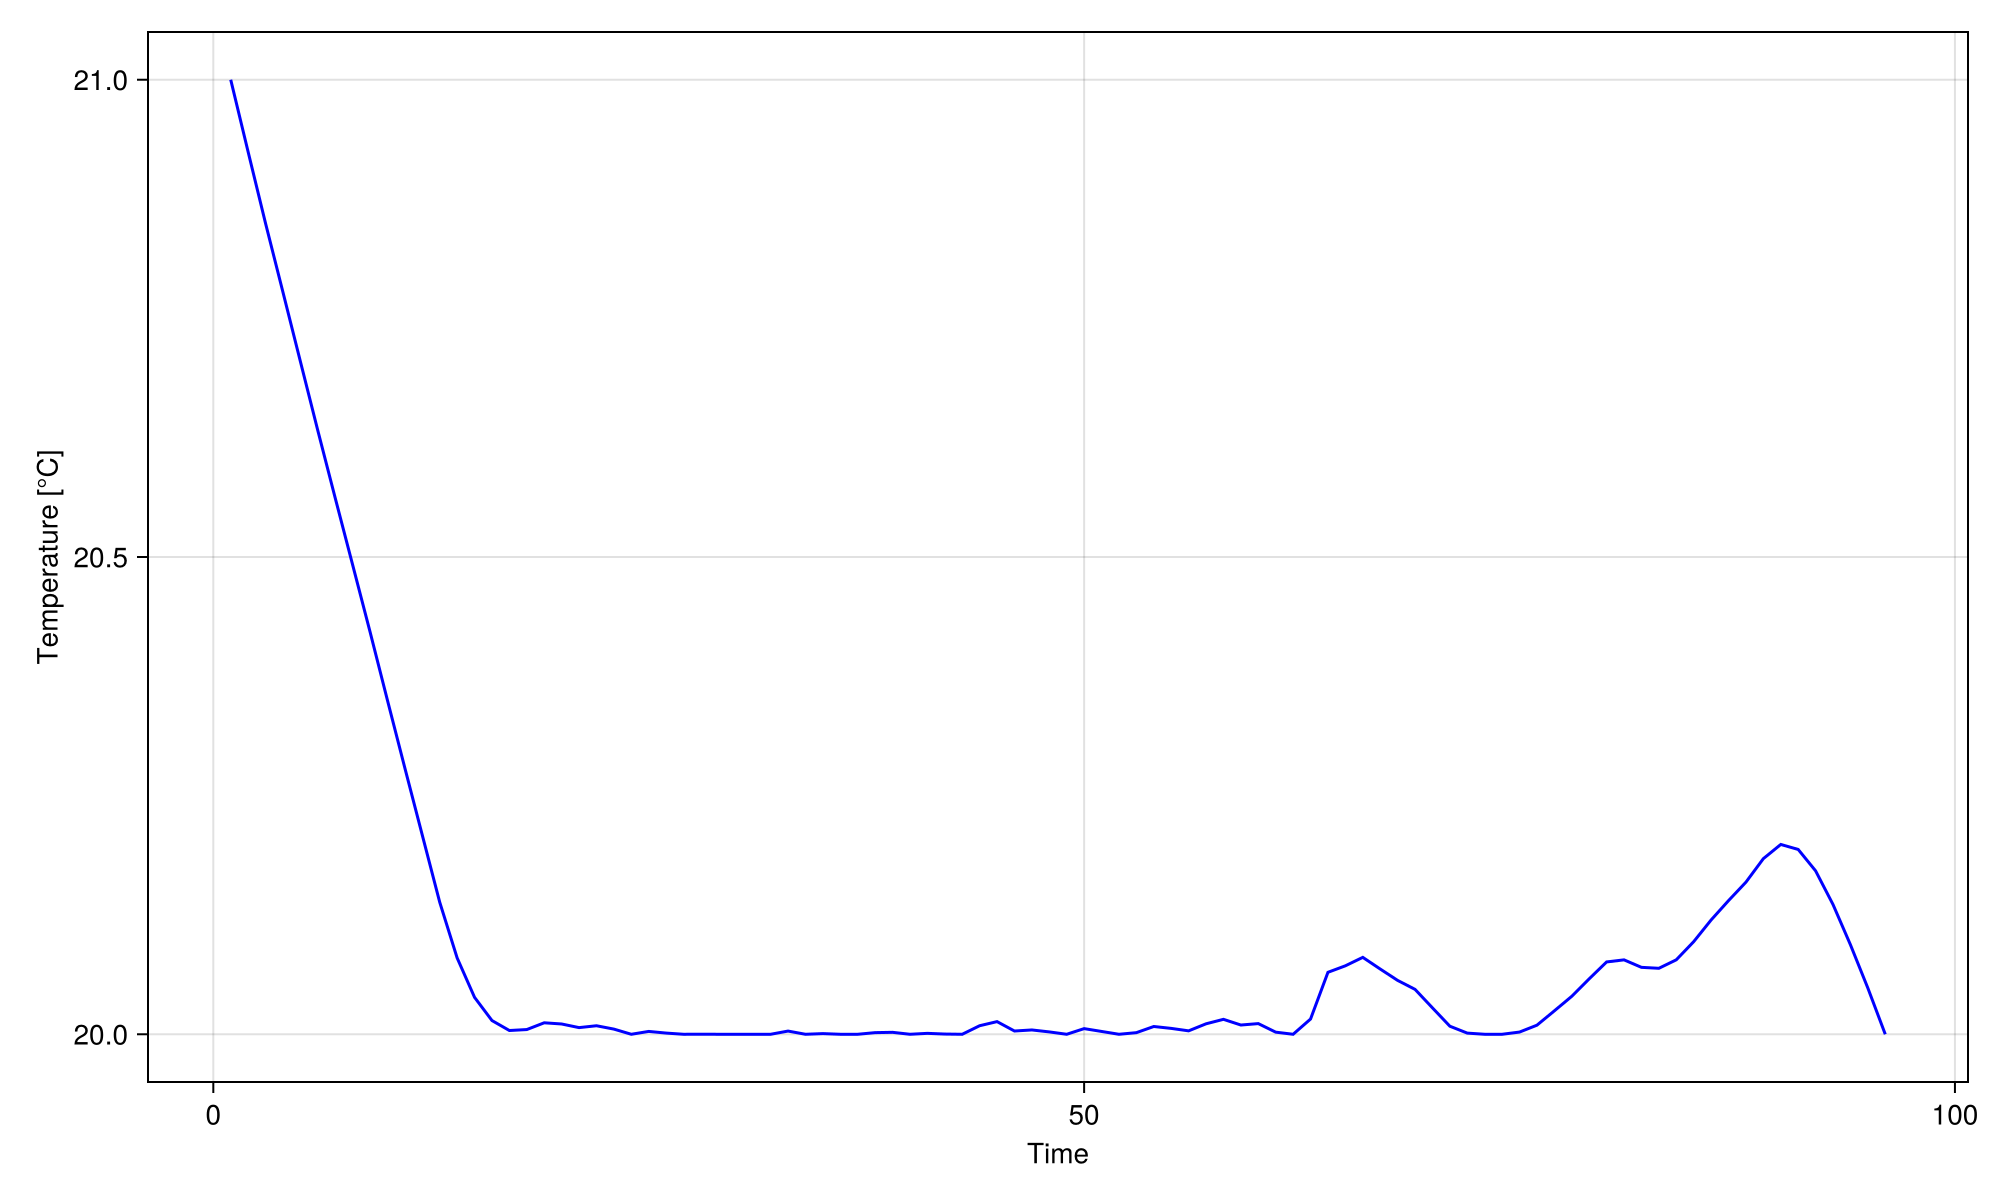

In [22]:
T_i_1 = Vector(value.(model[:Te])[:, 64, :i])
fig = Figure(; size = (1000, 600))

ax1 = Axis(fig[1,1], xlabel="Time", ylabel="Temperature [°C]")

lines!(ax1, T_i_1, color=:blue)

fig

In [23]:
function prepare_solution(model)
    # prepare JuMP solution for plotting
    sol = Dict{Symbol, Vector{Float64}}()
    for var in [:Q, :P_HP]
        sol[var] = vec(sum(Matrix{Float64}(value.(model[var]; result=1)), dims=2)) .* 1E3
    end

    return sol
end

prepare_solution (generic function with 1 method)

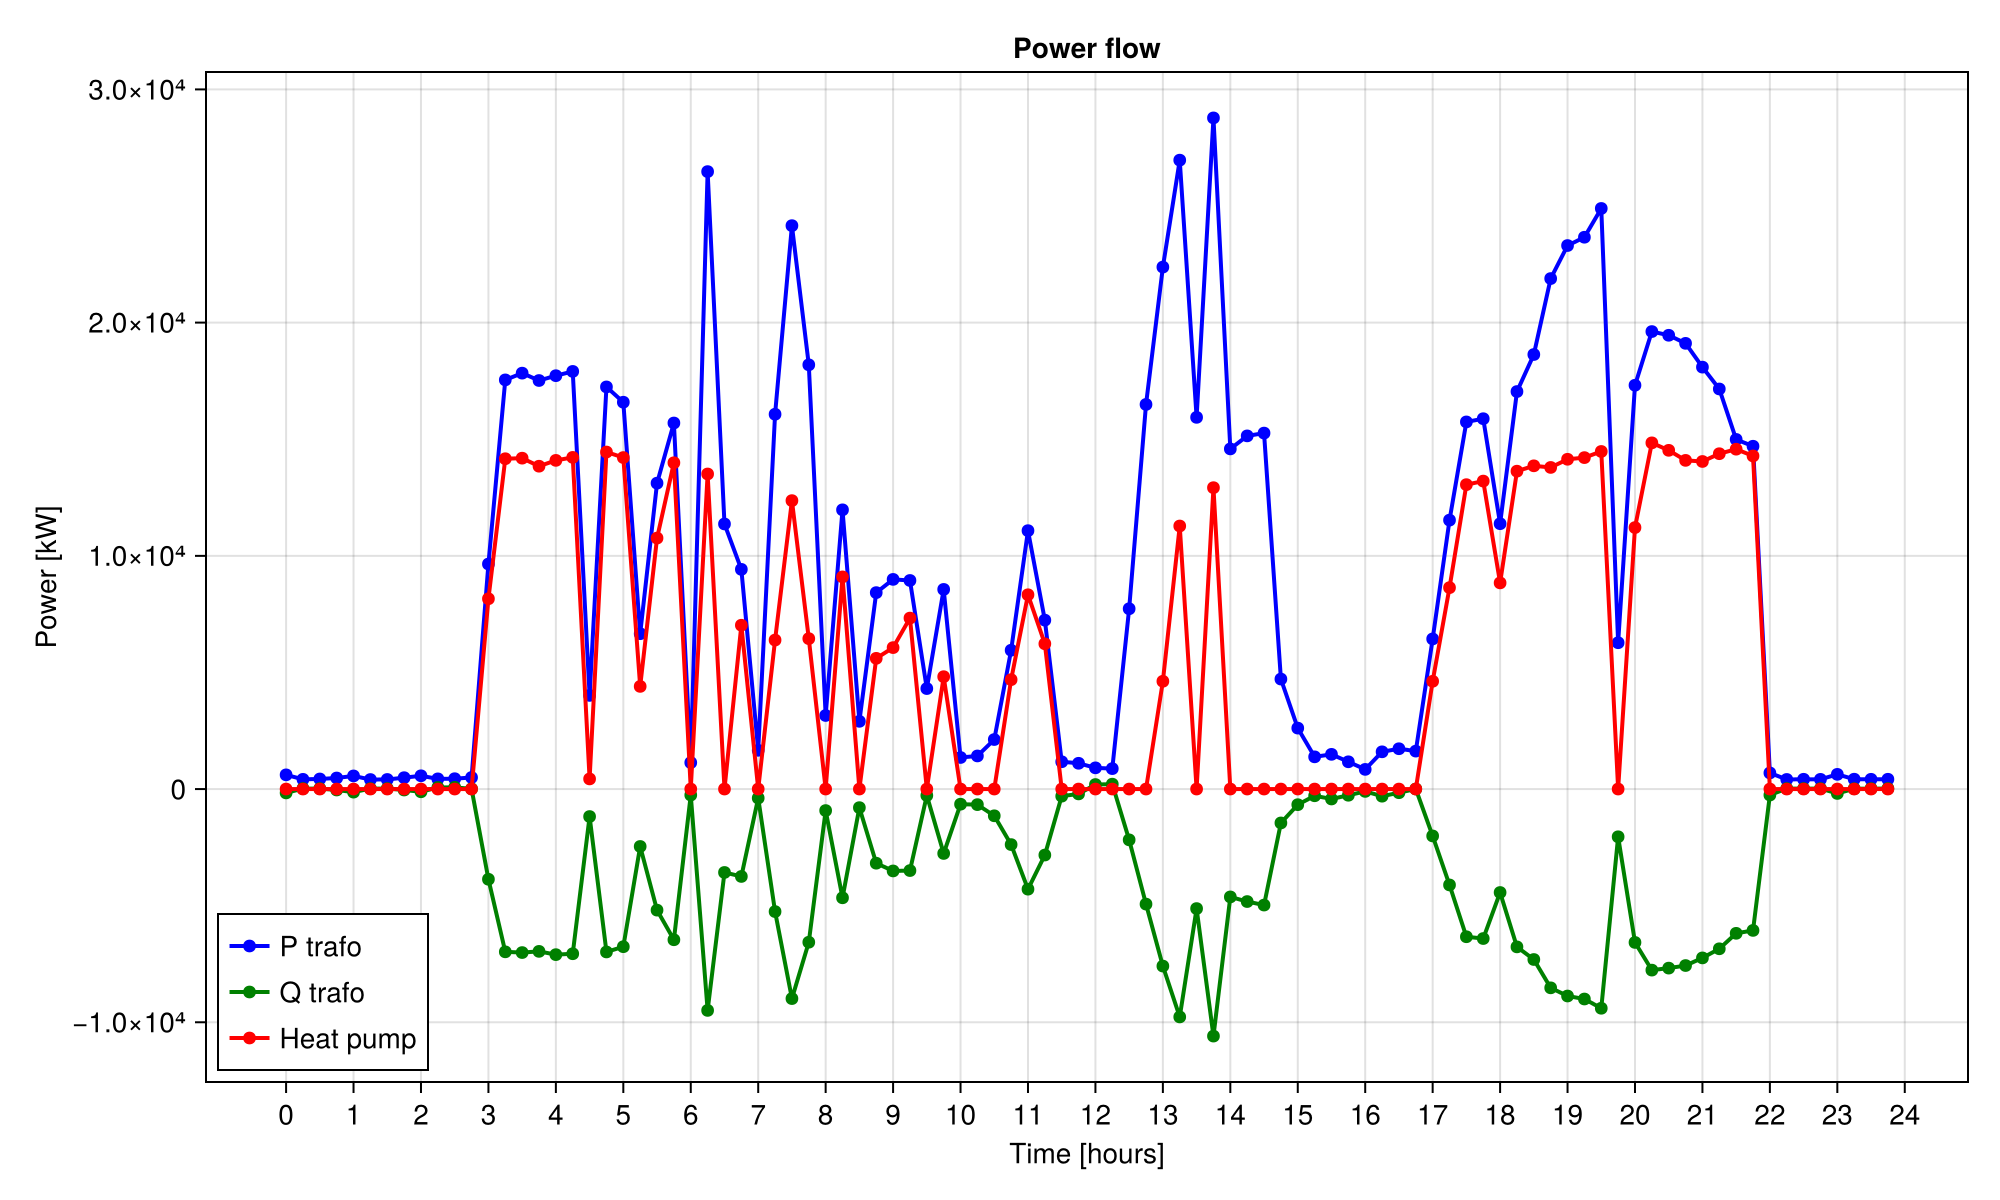

In [24]:
sol = prepare_solution(model)

# plot using Makie
fig = Figure(; size = (1000, 600))
ax = Axis(fig[1, 1], xlabel = "Time [hours]", 
    ylabel = "Power [kW]", 
    title = "Power flow",
    xticks = (1:4:97, string.(0:1:24))
)

# index of slack bus (transformer)
SB = argmin(value.(model[:P]).axes[2])
P_trafo = Matrix(value.(model[:P]; result=1))[:, SB] .* -1E3


# lines!(ax, sol[:P], color = :blue, label = "Transformer", linestyle = :so
scatterlines!(ax, P_trafo, color = :blue, label = "P trafo", linewidth = 2)
scatterlines!(ax, -sol[:Q], color = :green, label = "Q trafo", linewidth = 2)
scatterlines!(ax, sol[:P_HP], color = :red, label = "Heat pump", linewidth = 2)
axislegend(ax, merge = true, position = :lb)

# display
fig

## Plot total user power consumption

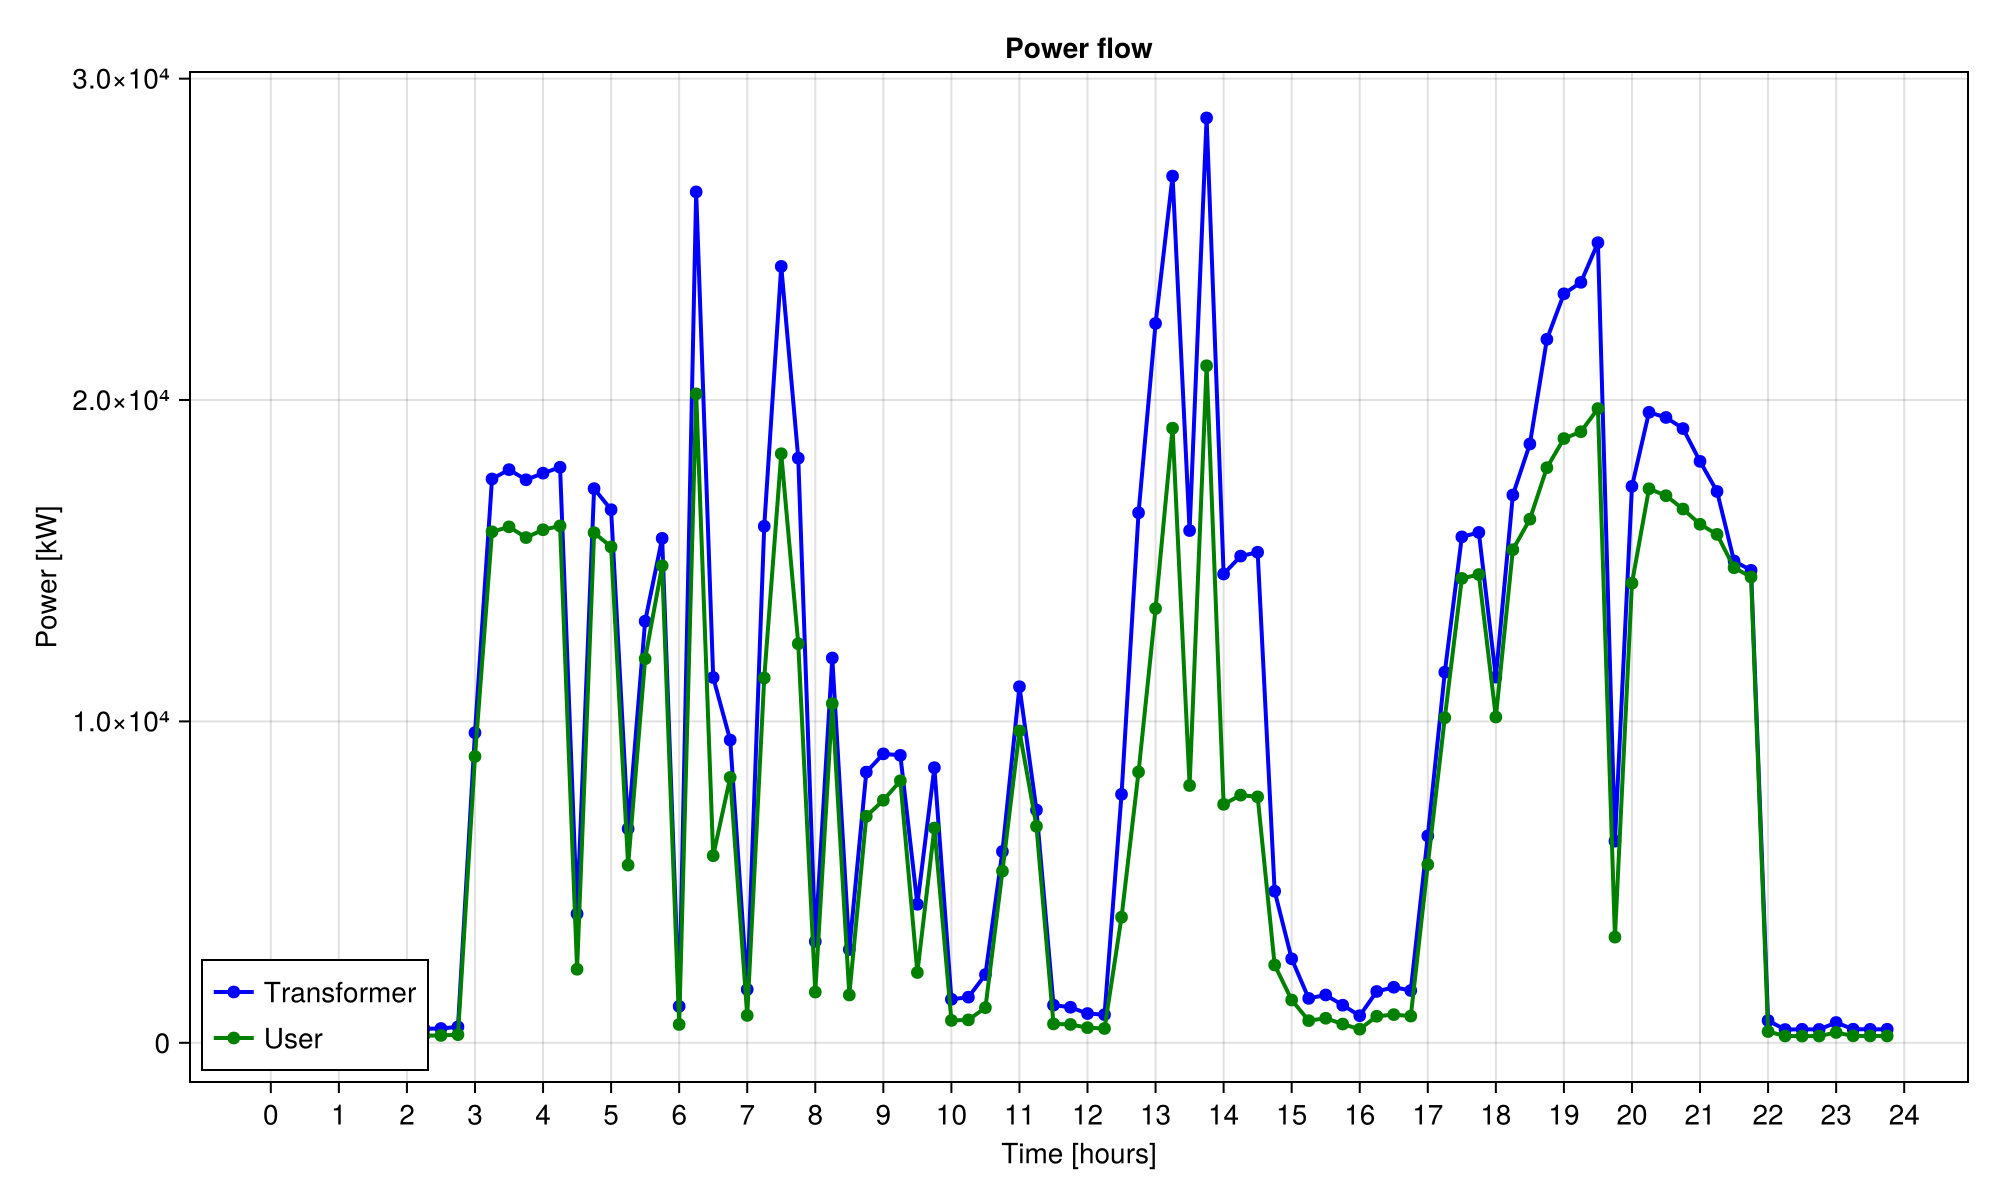

In [25]:
# plot using Makie
fig = Figure(; size = (1000, 600))
ax = Axis(fig[1, 1], xlabel = "Time [hours]", 
    ylabel = "Power [kW]", 
    title = "Power flow",
    xticks = (1:4:97, string.(0:1:24))
)

# transformer power
scatterlines!(ax, P_trafo, color = :blue, label = "Transformer", linewidth = 2)

# total user power
P_load_user = Vector(value.(model[:P_load_user]; result=1)) .* 1E3
scatterlines!(ax, P_load_user, color = :green, label = "User", linewidth = 2)

# display
axislegend(ax, merge = true, position = :lb)
fig

## Plot heat pump power consumption

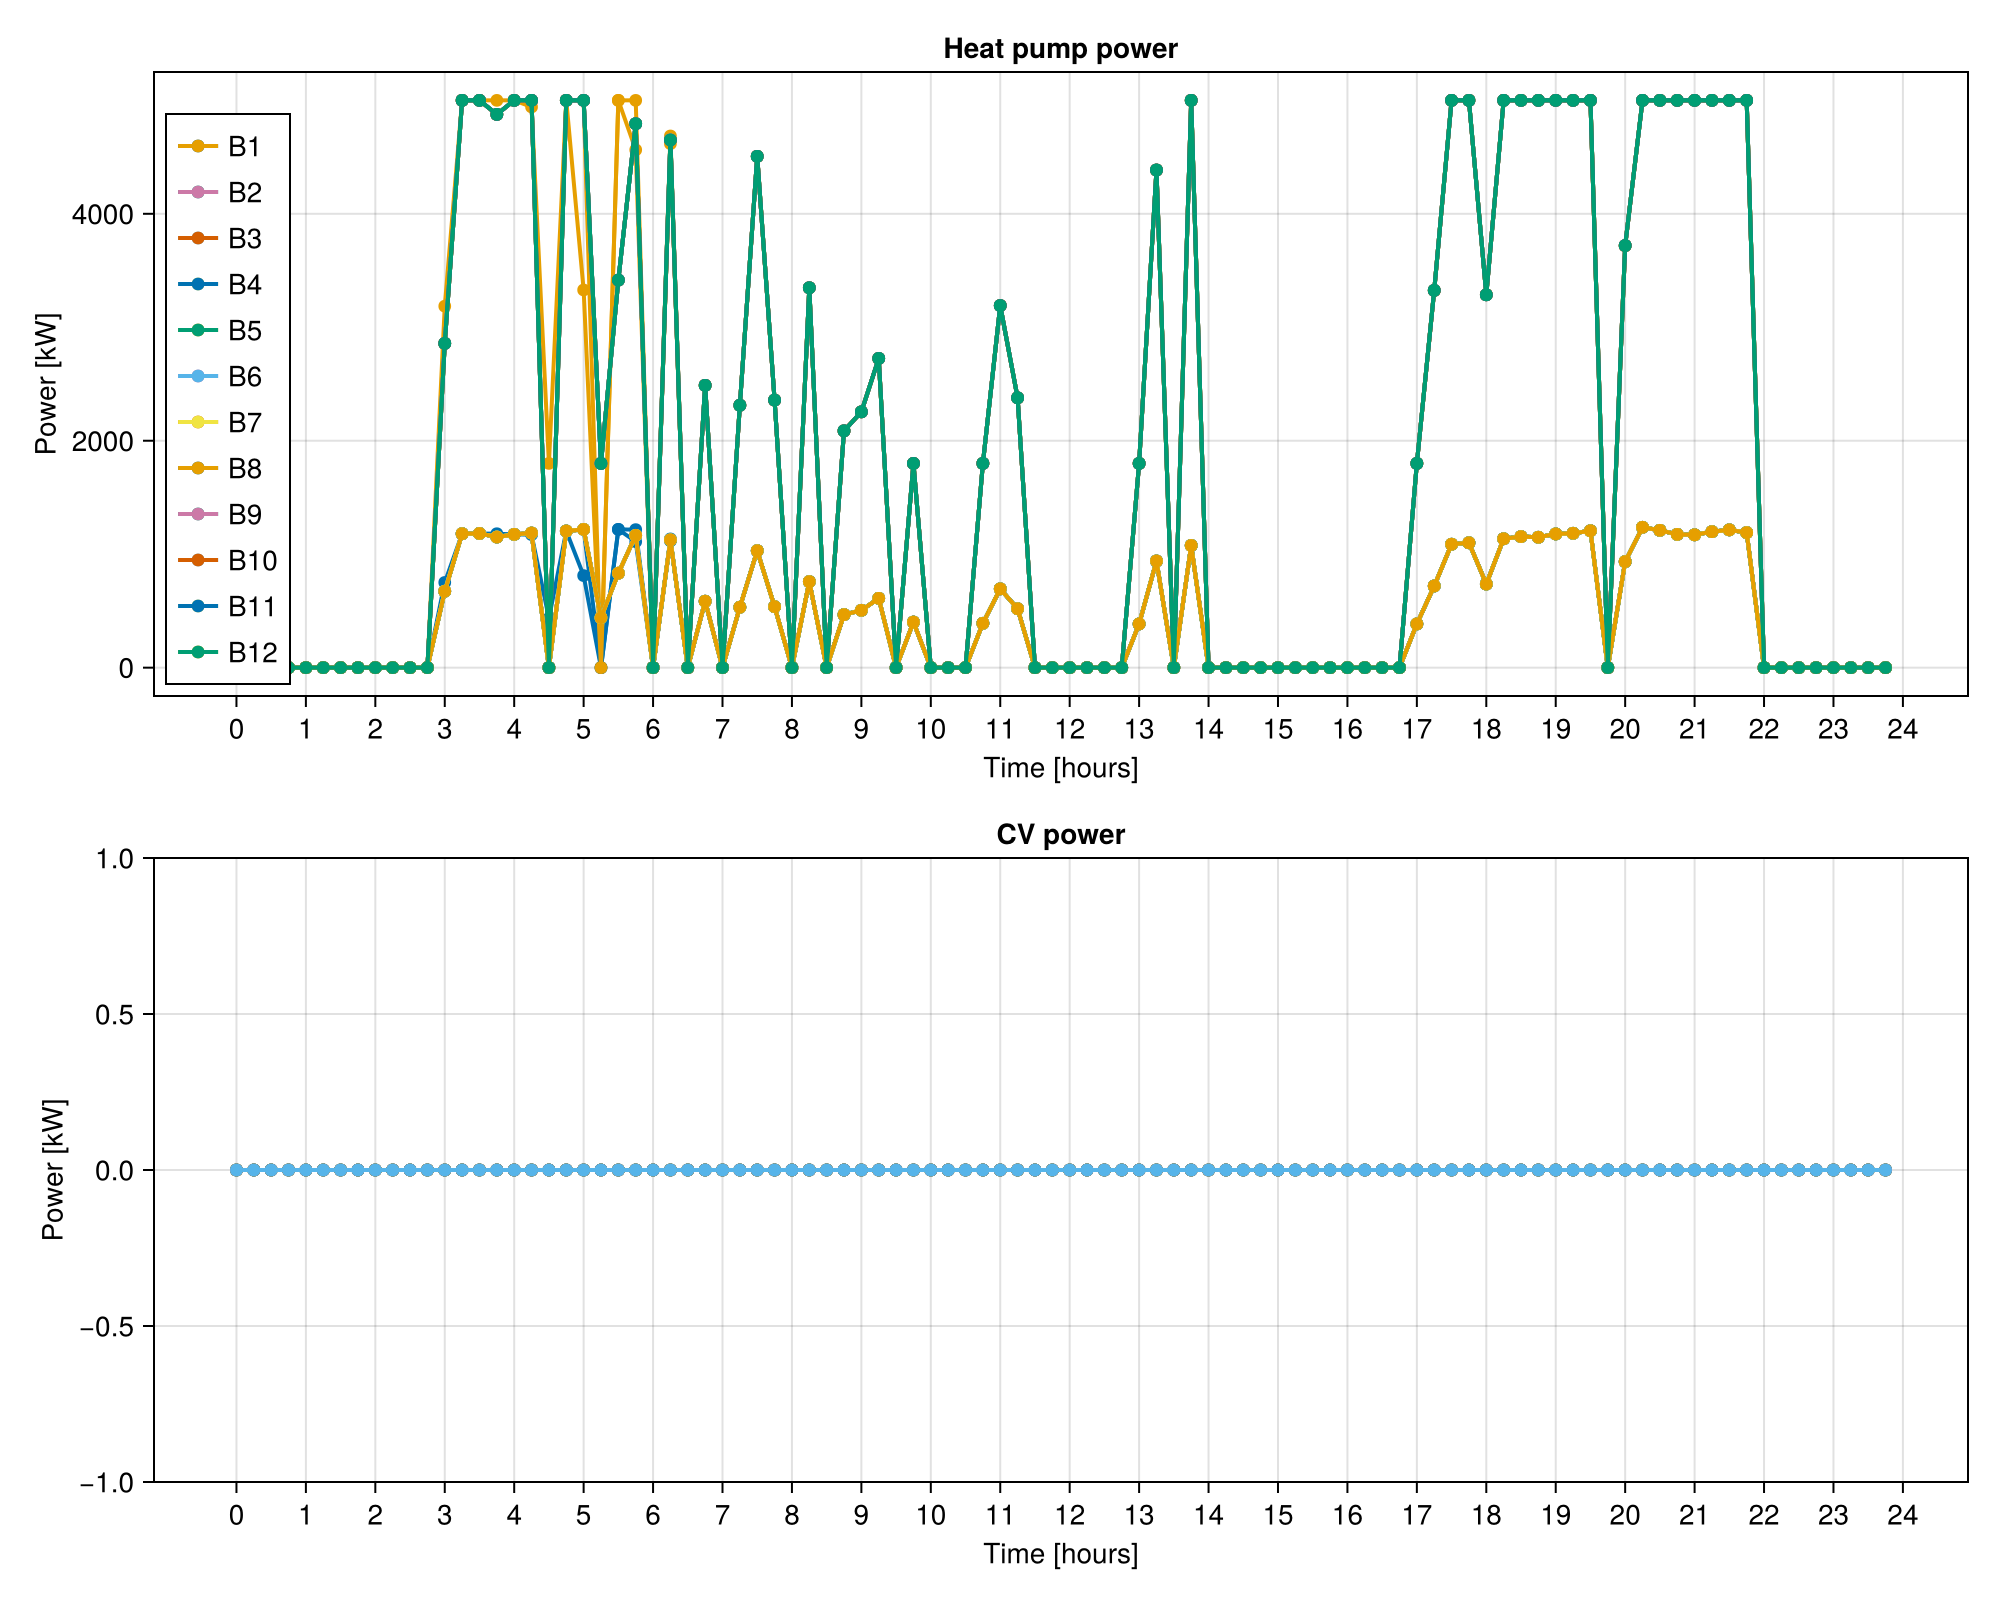

In [26]:
P_HP = Matrix(value.(model[:P_HP])) .* 1E3
Φ_HP = Matrix(value.(model[:Φ_HP])) .* 1E3
Φ_CV = Matrix(value.(model[:Φ_CV])) .* 1E3

fig = Figure(; size = (1000, 800))

# first row for HP power
ax1 = Axis(fig[1,1], xlabel = "Time [hours]", 
    ylabel = "Power [kW]", 
    title = "Heat pump power",
    xticks = (1:4:97, string.(0:1:24))
)
for i in 1:size(P_HP, 2)
    scatterlines!(ax1, P_HP[:, i], label = "B$i", linewidth = 2)
    scatterlines!(ax1, Φ_HP[:, i], label = "B$i", linewidth = 2)
end

# second row for CV power
ax2 = Axis(fig[2,1], xlabel = "Time [hours]", 
    ylabel = "Power [kW]", 
    title = "CV power",
    xticks = (1:4:97, string.(0:1:24))
)
for i in 1:size(Φ_CV, 2)
    scatterlines!(ax2, Φ_CV[:, i], label = "CV $i", linewidth = 2)
end

# legend 
axislegend(ax1, merge = true, position = :lb)

fig

## Testing outputs

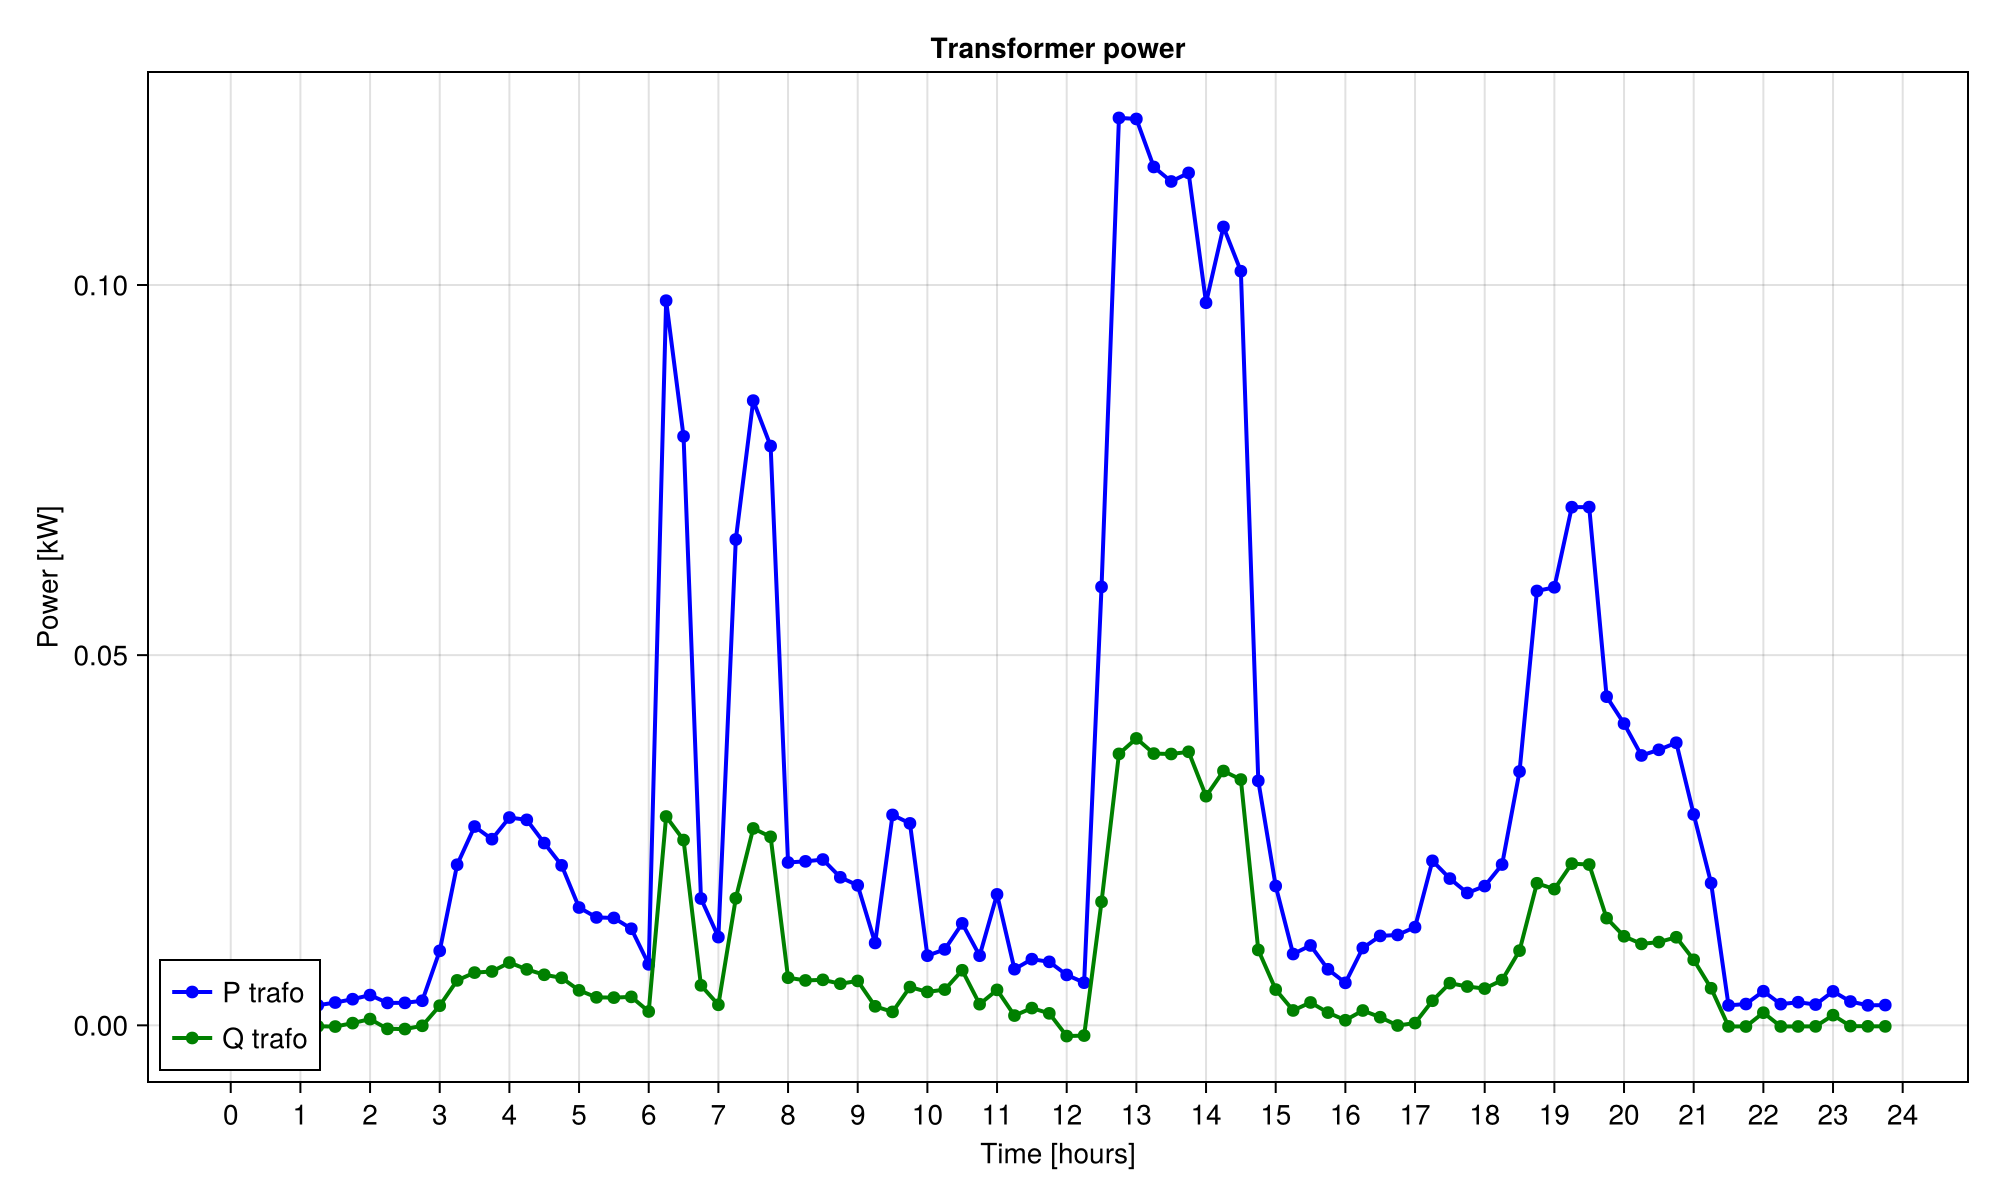

In [35]:
Q = Matrix(value.(model[:Q]))[:, 18]
P = Matrix(value.(model[:P]))[:, 18]

fig = Figure(; size = (1000, 600))
ax1 = Axis(fig[1,1], xlabel = "Time [hours]", 
    ylabel = "Power [kW]", 
    title = "Transformer power",
    xticks = (1:4:97, string.(0:1:24))
)
scatterlines!(ax1, P, color = :blue, label = "P trafo", linewidth = 2)
scatterlines!(ax1, Q, color = :green, label = "Q trafo", linewidth = 2)
axislegend(ax1, merge = true, position = :lb)
fig

In [30]:
SB

55